<a href="https://colab.research.google.com/github/armitakar/GGS366_Spatial_Computing/blob/main/Lectures/8_2_Point_pattern_analysis_Density_based_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We perform **density-based analysis to examine the variations in concentration and intensity of point events across space.** In this lecture, we will discuss two main approaches: **quadrat density** and **kernel density**.

Further reading:
- https://pygis.io/docs/e_summarize_vector.html
- https://mgimond.github.io/Spatial/chp11_0.html#centrography
- https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-kernel-density-works.htm

Codes in this lecture is adopted from https://pygis.io/docs/e_summarize_vector.html and modified where appropriate.


# Library

In [ ]:
!pip install contextily

In [ ]:
# libraries for reading and processing the spatial data
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Polygon

# libraries for calculating the summary statistics
import numpy as np
import math

# libraries for visualiations
import matplotlib.pyplot as plt
import contextily as cx

# libraries for kernel density
from sklearn.neighbors import KernelDensity

# Data

We will use the Virginia crash data for this lecture. We retrieve the data from here: https://www.virginiaroads.org/datasets/VDOT::crashdata-basic-1/explore.

In [ ]:
import requests

# Base URL for the FeatureServer
base_url = "https://services.arcgis.com/p5v98VHDX9Atv3l7/arcgis/rest/services/CrashData_test/FeatureServer/0/query"

# Function to fetch data in batches
def fetch_all_data(year, data_crs):
    all_data = []
    offset = 0
    batch_size = 2000  # ArcGIS default max

    while True:
        params = {
            "outFields": "*",
            "where": f"CRASH_YEAR = {year}",
            "f": "geojson",
            "resultOffset": offset,
            "resultRecordCount": batch_size
        }

        response = requests.get(base_url, params=params)

        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            break

        data = response.json()

        # Convert to GeoDataFrame and append
        gdf = gpd.GeoDataFrame.from_features(data["features"])
        all_data.append(gdf)

        # If fewer records returned than batch size, stop
        if len(gdf) < batch_size:
            break

        offset += batch_size  # Move to the next batch
    final_df = pd.concat(all_data, ignore_index=True)
    final_gdf = gpd.GeoDataFrame(final_df, geometry='geometry', crs=data_crs) # make sure to check the crs from metadata
    return final_gdf

In [ ]:
# Loading all crash data
crash = fetch_all_data(2022, 4326)

# Checking total records loaded
print(f"Total records loaded: {len(crash)}")

# removing any null geometries
crash = crash.dropna(subset=['geometry'])

# converting to projected CRS for accurate distance measures
crash = crash.to_crs(epsg = 3857)

Total records loaded: 122434


<Axes: >

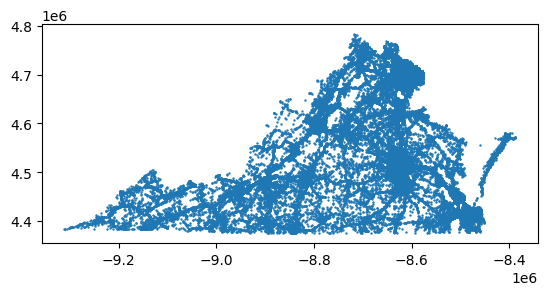

In [ ]:
crash.plot(markersize = 0.5)

# Quadrat density

In this method, we divide the study area into **equal-sized quadrats or grid cells** using various shapes (e.g., squares, hexagons, or rectangles). The **density** is then calculated as **the number of data points within each quadrat or grid cell**.

In [ ]:
# function to create square grid
def create_grid(df, grid_size):
    # Get bounds from GeoDataFrame
    xmin, ymin, xmax, ymax = df.total_bounds

    # determine columns and rows based on grid cell size
    cols = list(np.arange(xmin, xmax + grid_size, grid_size))
    rows = list(np.arange(ymin, ymax + grid_size, grid_size))

    # empty list that we will use to store the grid cells
    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+grid_size, y), (x+grid_size, y+grid_size), (x, y+grid_size)]))

    # convert it to geodataframe
    grid = gpd.GeoDataFrame({'geometry': polygons}, crs=df.crs)

    # add a unique ID for each grid cell
    grid['Grid_ID'] = np.arange(len(grid))

    # return grid
    return grid

To estimate quadrat density for each grid cell, the first step is to **spatially join each crash location to a grid cell**. Here, we can not perform *“sjoin”* using a *“within”* predicate because some points might be located on the grid cell boundary. A *“within”* predicate will omit those points. However, an *“intersects”* predicate will double-count those points on cell boundaries; we need to drop those before performing further density calculation.

Once the points in each grid cell is computed, the density in each gridcell can be estimated by dividing the number of points in each gridcell by its area.

In [ ]:
# function to estimate quadrat density
def quadrat_density(point, grid_size):

    # Creating grid
    grid = create_grid(df = point,              # specify the point dataset
                       grid_size = grid_size)   # side length of grid cell shapes

    # spatial joining each point location to a grid cell
    point_grid1 = gpd.sjoin(point, grid, predicate='intersects')

    # Removing duplicate counts
    point_grid1 = point_grid1.drop_duplicates(subset = ['OBJECTID']).reset_index()

    # Aggregating the point location counts by grid cells
    point_grid2 = point_grid1.groupby('Grid_ID').agg({'OBJECTID':'count'}).reset_index()

    # the group by function only returns the grid cells with a non-zero point count
    # for better visualization, we can merge it with all grid cell data
    point_grid3 = grid.merge(point_grid2, on = 'Grid_ID', how = "left")
    point_grid3 = point_grid3.rename(columns = {'OBJECTID':'Count'})

    # Fill the NaN values (cells without any points) with 0
    point_grid3['Count'] = point_grid3['Count'].fillna(0)

    # Calculate density
    point_grid3['Area_in_sqkm'] = point_grid3.area * 0.000001
    point_grid3['Density'] = point_grid3['Count'] / point_grid3['Area_in_sqkm'] # Density per sq.km

    # return grid
    return point_grid3

In [ ]:
# Estimating quadrat density for our crash data
crash_quad_den = quadrat_density(crash, 5000)

# identifying grid cells that fall only within VA for the remaining analysis.
# virginia boundary data from census.gov
state = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2022/STATE/tl_2022_us_state.zip")
va = state[state['STATEFP'] == '51']
va = va.to_crs(epsg = 3857)

# retain the grids that fall in VA boundary
crash_quad_den = gpd.sjoin(crash_quad_den, va, predicate='within')


Text(0.5, 1.0, 'Crash Densities in Virginia using Quadrat Density Estimation')

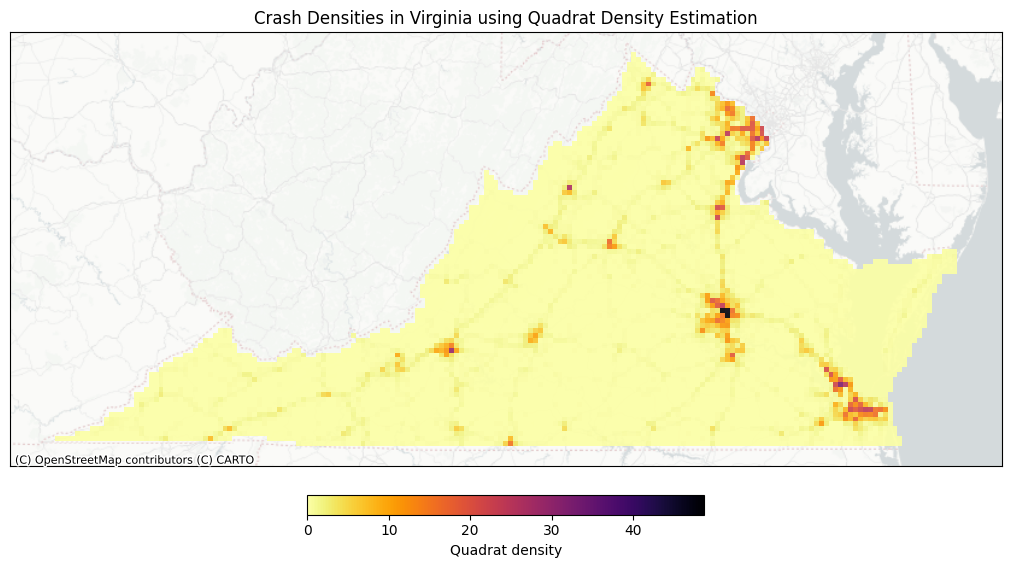

In [ ]:
# Creating the figure and axes first
fig, ax = plt.subplots(figsize=(10, 6),
                       layout = 'constrained')  # contrained layout helps to avoid unnecessary white space

# Plotting the polygon layer
plot1 = crash_quad_den.plot(ax = ax,                     # asking to plot the layer within the defined axes
                   column = "Density",                   # column values to be used for the color scheme
                   cmap = 'inferno_r', alpha = 0.9,      # colormap to be used and the transparency parameter
                   legend = True,                        # show legend
                   legend_kwds={'label': "Quadrat density",        # legend label
                                'orientation': "horizontal",       # legend orientation
                                'shrink': 0.4})                    # modify legend length and width

# Adding basemap from the contextily library (loaded as cx)
cx.add_basemap(
    ax =ax,
    crs="EPSG:3857",
    source=cx.providers.CartoDB.PositronNoLabels
);

# remove axes tick labels (lat-long labels)
ax.set_xticks([])
ax.set_yticks([])

# add a map title
ax.set_title('Crash Densities in Virginia using Quadrat Density Estimation')

One **disadvantage of quadrat density** is that the estimates may be biased with the [modifiable areal unit problem (MAUP)](https://gisgeography.com/maup-modifiable-areal-unit-problem/):
- If the gridcells are too small, many will have low or zero density, potentially obscuring patterns.
- If the gridcells are too large, the result may be overly smoothed, losing local variations in density.

To learn more about MAUP, you may read this article written by Dr. David Wong:
- Wong, D. W. (2004). The modifiable areal unit problem (MAUP). In WorldMinds: geographical perspectives on 100 problems: commemorating the 100th anniversary of the association of American geographers 1904–2004 (pp. 571-575). Dordrecht: Springer Netherlands.


# Kernel density estimation

Kernel Density Estimation (KDE) mitigates the effects of the Modifiable Areal Unit Problem (MAUP) by using a probabilistic approach. Unlike quadrat density that count points in predefined areas, KDE creates **a continuous density surface** that reflects event intensity, considering the distance between points.

Here’s how KDE works:
- A **kernel function is applied around each point observation**, assuming its influence extends beyond its location to surrounding areas. The kernel’s effect is strongest at the point location and decays with distance, being zero beyond its bandwidth (kernel radius). The **most common kernel is Gaussian**, which follows a normal distribution. The **bandwidth controls how far the kernel spreads**—larger bandwidths mean a wider influence, while smaller bandwidths focus on nearby areas. Combining all kernels forms a global smooth density surface.
- Like quadrat density, the **study area is divided into grid cells**. For each grid cell, the **density is calculated by summing the values of all the kernel surfaces** overlapping at the gridcell center.
- The output measure reflects expected number of events per unit area.


We will use **scikit-learn** library to estimate kernel density.

In [ ]:
# functions for kernel density estimation
def kernel_density(point, grid_size, kernel, kernel_bandwidth, dist_metric):

    # Creating grid
    grid = create_grid(df = point,              # specify the dataset
                       grid_size = grid_size)   # side length of grid cell shapes

    # Estimating centroids of each gridcell
    grid_cent = grid.copy()
    grid_cent["geometry"] = grid["geometry"].centroid

    # Creating 2-D array of the paired coordinates of each gridcell
    positions_sk = np.vstack([grid_cent["geometry"].x, grid_cent["geometry"].y]).T

    # Creating 2-D array of the paired coordinates of each point locations (train dataset)
    point = point.dropna(subset=['geometry'])
    Xtrain_geom = np.vstack([point["geometry"].x, point["geometry"].y]).T

    # Define a kernel density estimator that sets all the parameters to be used to calculate the kernel density function
    # parameters can be changed, see their descriptions here:
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity
    kde = KernelDensity(bandwidth = kernel_bandwidth,        # can be assigned any bandwidth value
                        metric = dist_metric,                # options: euclidean, haversine, manhattan, etc
                        kernel = kernel)                     # options: gaussian, exponential, linear etc

    # Fit kernel density estimator to the training data
    kde_fit = kde.fit(Xtrain_geom)

    # Evaluate the estimator on each gridcell coordinate pairs to get their probability density
    prob_den = np.exp(kde_fit.score_samples(positions_sk))
    grid["KDE"] = prob_den
    return grid

In [ ]:
# KDE estimation for our crash dataset
KDE = kernel_density(point = crash,
                     grid_size = 5000,
                     kernel = "gaussian",
                     kernel_bandwidth = 15000,
                     dist_metric = "euclidean")

# retain the grids that fall in VA boundary
KDE = gpd.sjoin(KDE, va, predicate='within')

Text(0.5, 1.0, 'Crash Densities in Virginia using Kernel Density Estimation')

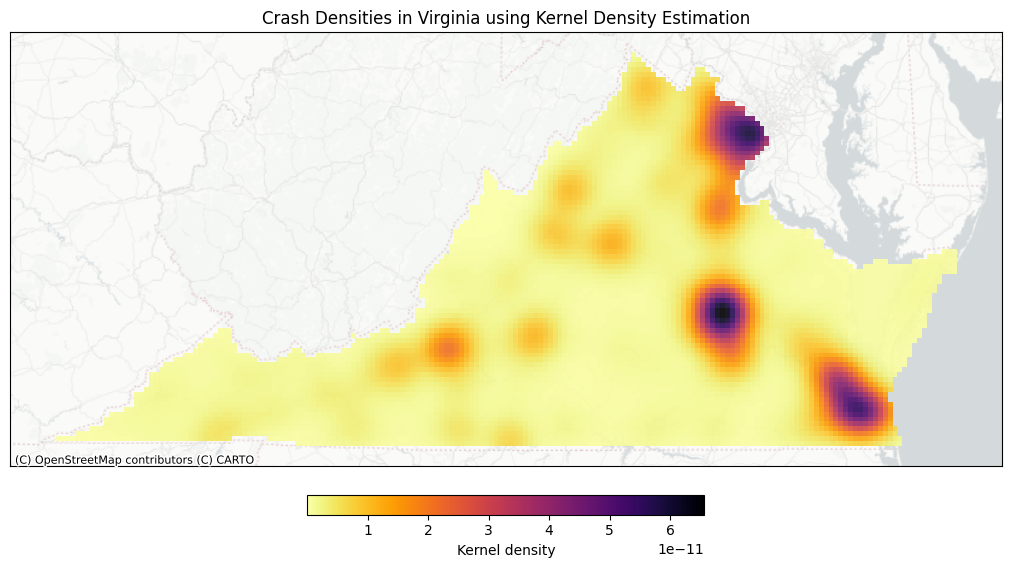

In [ ]:
# Creating the figure and axes first
fig, ax = plt.subplots(figsize=(10, 6),
                       layout = 'constrained')  # contrained layout helps to avoid unnecessary white space

# Plotting the polygon layer
plot1 = KDE.plot(ax = ax,                                # asking to plot the layer within the defined axes
                   column = "KDE",                       # column values to be used for the color scheme
                   cmap = 'inferno_r', alpha = 0.9,      # colormap to be used and the transparency parameter
                   legend = True,                        # show legend
                   legend_kwds={'label': "Kernel density",         # legend label
                                'orientation': "horizontal",       # legend orientation
                                'shrink': 0.4})                    # modify legend length and width

# Adding basemap from the contextily library (loaded as cx)
cx.add_basemap(
    ax =ax,
    crs="EPSG:3857",
    source=cx.providers.CartoDB.PositronNoLabels
);

# remove axes tick labels (lat-long labels)
ax.set_xticks([])
ax.set_yticks([])

# add a map title
ax.set_title('Crash Densities in Virginia using Kernel Density Estimation')

Bandwidth parameter is the most important parameter, which determines how far each point spreads its influence. Choosing the right bandwidth is key:

- Too **Small** bandwidth → **Overfitting** (highly localized, noisy patterns).
- Too **Large** bandwidth → **Oversmoothing** (loses detail, blurs hotspots).
